# [Task] Predict the selling price for the [Vehicle Dataset](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho)

### Load the dataset, perform all necessary data exploration and preprocessing

### Perform proper hyperparameter tuning to choose the best base model, depth, max_features, and any other important hyper-parameters 

# [Vehicle Dataset - V3](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho)

## A- Exploratory Data Analysis

In [1]:
#import needed libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, MultiTaskLassoCV, LassoLarsCV, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, LeaveOneOut
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, mean_squared_error, r2_score, roc_auc_score, mean_absolute_error, f1_score
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
df=pd.read_csv('./Car details v3.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [4]:
df.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


### 1) Data Transformation 

In [5]:
# Data Transformation 
data=df.copy(deep=True)
df['mileage']= df['mileage'].str.extract(r'(\d+.\d+)').astype('float')
df['engine']=df['engine'].str.extract('(^\d*)')
df['max_power']=df['max_power'].str.extract('(^\d*)')
#Torque Extraction
df['torque']= df['torque'].str.extract('(^\d*)')
df['torque']= df['torque'].fillna(150)
df['torque']= df['torque'].astype(int)
#df['torque']= df[df['torque']<=50]['torque']*9.8
df['torque'] = df['torque'].apply(lambda x: 9.8*x if x <= 50 else x)
### Ordinal Encoding ###
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()

df["fuel"] = ord_enc.fit_transform(df[["fuel"]])
df["seller_type"] = ord_enc.fit_transform(df[["seller_type"]])
df["transmission"] = ord_enc.fit_transform(df[["transmission"]])
df["owner"] = ord_enc.fit_transform(df[["owner"]])
df["name"] = ord_enc.fit_transform(df[["name"]])

df.dropna(inplace=True)
df['engine']=df['engine'].astype(int)
df['max_power']=df['max_power'].dropna()
df['max_power'].replace({'': 0}, inplace=True)
df['max_power']=df['max_power'].astype(int)

### 2) Univariate Analysis

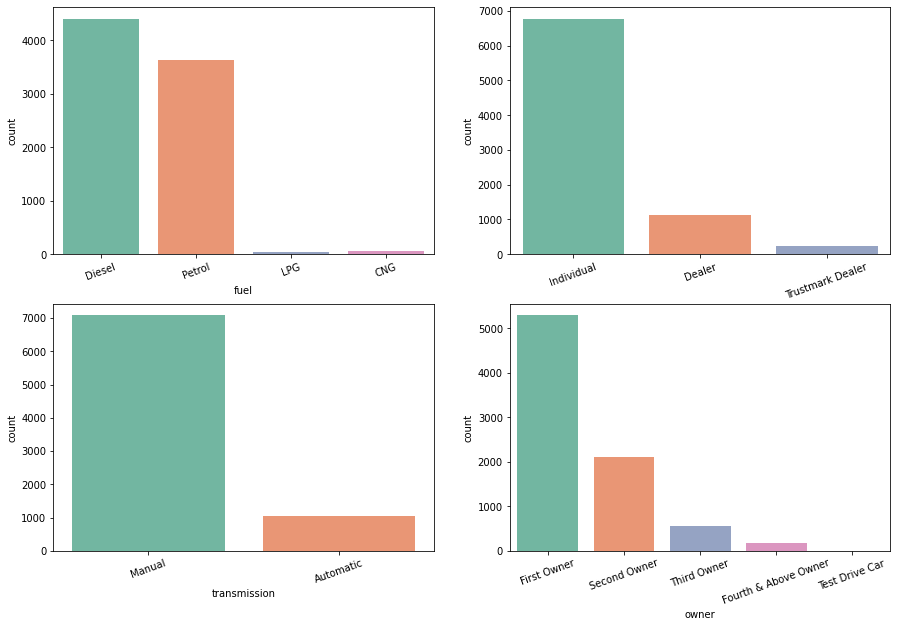

In [6]:
cat_cols = ['fuel','seller_type','transmission','owner']
fig = plt.figure(figsize=[15,10])
for i in range(len(cat_cols)):
    plt.subplot(2,2,i+1)
    ax= sns.countplot(x=cat_cols[i], data=data, palette= 'Set2')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 20)

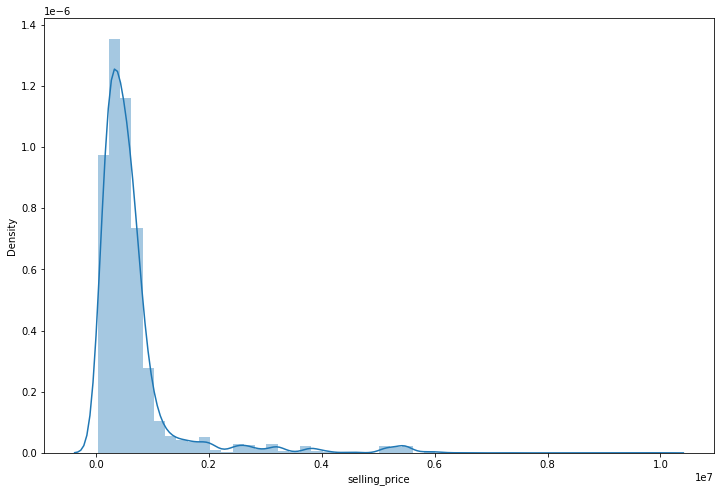

In [7]:
plt.subplots(figsize=(12,8))
sns.distplot(df['selling_price']);

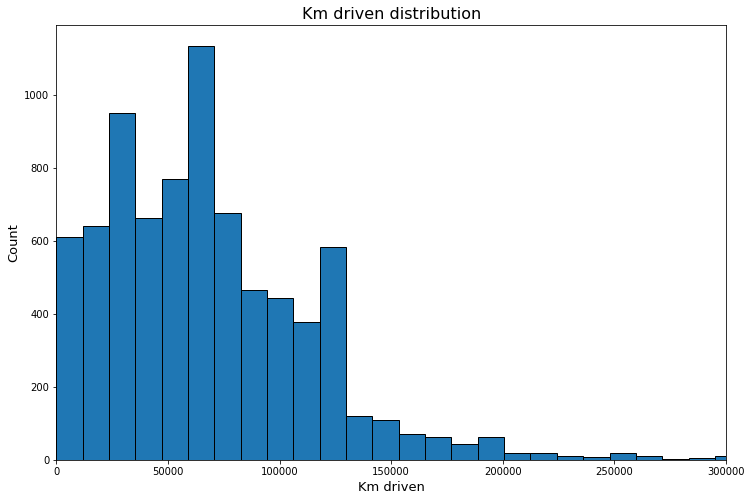

In [8]:
plt.subplots(figsize=(12,8))
plt.hist(df['km_driven'], bins= 200,edgecolor='black');
plt.xlim([0, 300000]);
plt.xlabel('Km driven', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Km driven distribution', fontsize=16);

In [9]:
df.corr().selling_price.sort_values().to_frame()

,selling_price
transmission,-0.590279
seller_type,-0.337035
owner,-0.224481
km_driven,-0.222196
fuel,-0.193116
mileage,-0.126054
name,-0.072543
seats,0.041358
year,0.412268
engine,0.455734


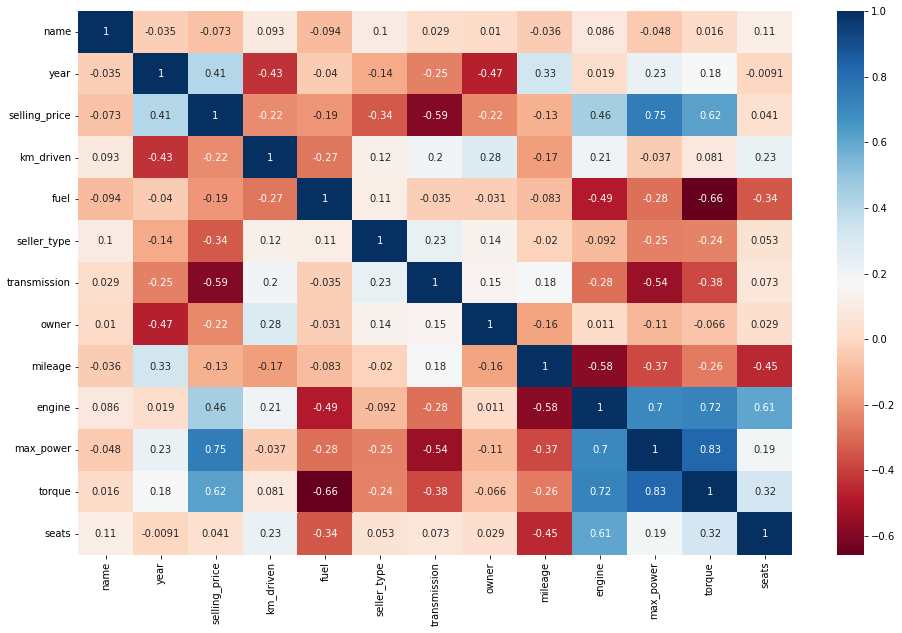

In [10]:
plt.subplots(figsize=(16,10))
sns.heatmap(df.corr(), annot=True, cmap="RdBu")
plt.show()

## B- Train/Test Models

In [11]:
X= df.drop('selling_price', axis=1)
y= df[['selling_price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1) Linear Regression

In [12]:
lin_reg= Ridge()
lin_reg.fit(X_train, y_train)
y_pred= lin_reg.predict(X_test)
print('R2 Score for Linear Regression on test data: {}'.format( np.round(r2_score(y_test, y_pred), 3)))

R2 Score for Linear Regression on test data: 0.685


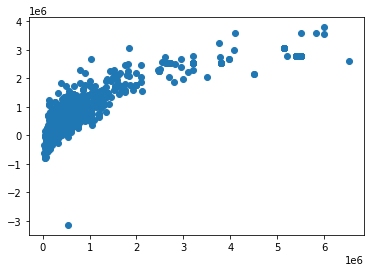

In [13]:
plt.scatter(y_test,y_pred);

### 2) Random Forest Regressor

In [14]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [15]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
%time _= rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
CPU times: user 28 s, sys: 2.19 s, total: 30.2 s
Wall time: 12min 46s


In [16]:
rf_random.best_params_, rf_random.best_score_

({'bootstrap': False,
  'max_depth': 40,
  'max_features': 'sqrt',
  'n_estimators': 1800},
 0.9636729298137787)

In [17]:
rf= RandomForestRegressor(**rf_random.best_params_)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      n_estimators=1800)

#### CV Score

In [18]:
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
print('R2 Score CV for RandomForest = {}'.format( np.round(scores.mean(),2)))

R2 Score CV for RandomForest = 0.97


#### Train Score

In [19]:
y_pred= rf.predict(X_train)
print('RandomForestRegressor results on train data: R2 Score: {}  - MSE Score: {}'.format(r2_score(y_train, y_pred),mean_squared_error(y_train, y_pred )))

RandomForestRegressor results on train data: R2 Score: 0.9998527730545239  - MSE Score: 94271074.99569862


#### Test Score

RandomForestRegressor results on train data: R2 Score: 0.9835100672347857  - MSE Score: 12327199892.393084


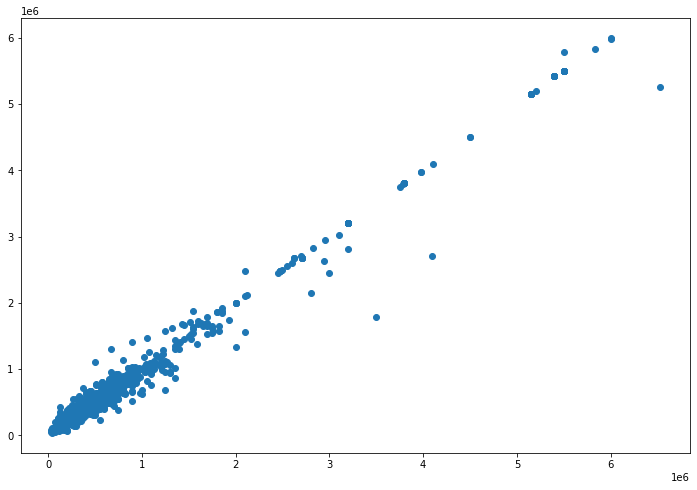

In [51]:
y_pred= rf.predict(X_test)
print('RandomForestRegressor results on train data: R2 Score: {}  - MSE Score: {}'.format(r2_score(y_test, y_pred),mean_squared_error(y_test, y_pred)))
plt.figure(figsize=(12,8))
plt.scatter(y_test,y_pred);

#### Feature Importance

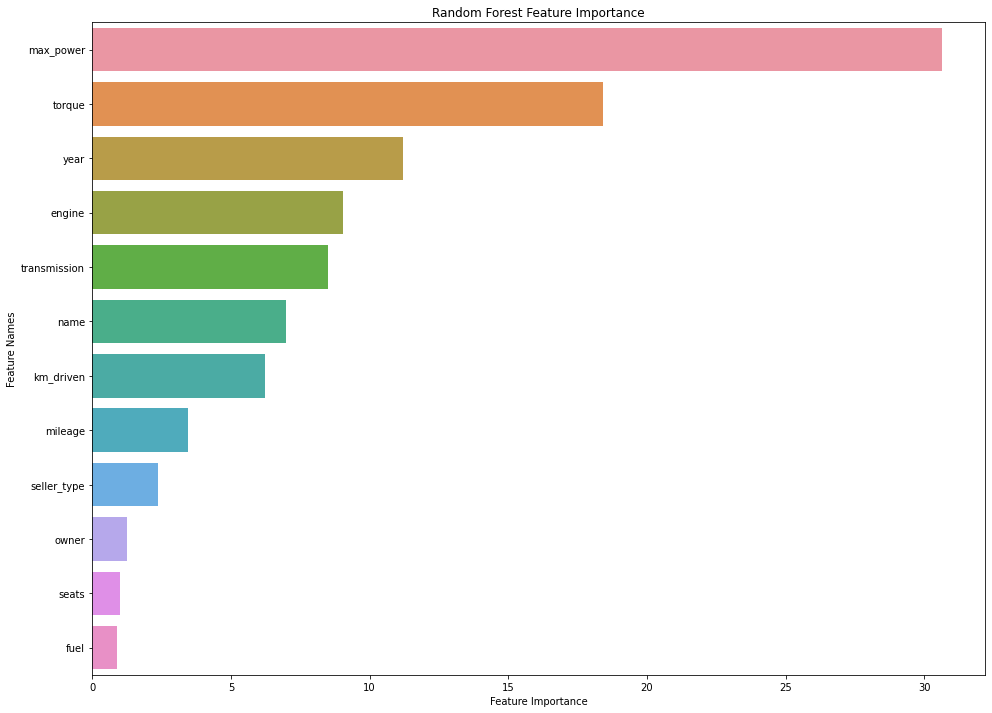

In [53]:
data={'feature_names':X_train.columns,'feature_importance':rf.feature_importances_}
fi_df = pd.DataFrame(data)
#Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
plt.figure(figsize=(16,12))
sns.barplot(x=fi_df['feature_importance']*100, y=fi_df['feature_names']);
plt.title( 'Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

### 3) LGBM Regressor 

In [48]:
lgb_reg= LGBMRegressor()
lgb_reg.fit(X_train, y_train)
y_pred= lgb_reg.predict(X_test)
r2_score(y_test, y_pred )

0.981598386228063

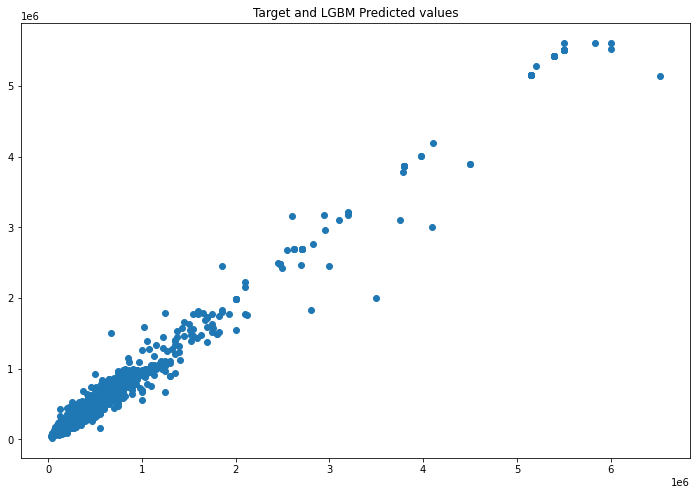

In [50]:
plt.figure(figsize=(12,8))
plt.scatter(y_test,y_pred);
plt.title('Target and LGBM Predicted values');

### Learning Curves

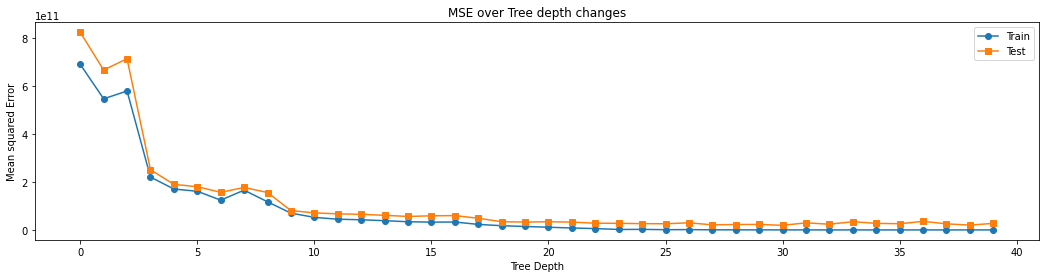

In [47]:
train_scores, test_scores = list(), list()
values = [i for i in range(40)]
# evaluate a decision tree for each depth
for i in values:
	model = DecisionTreeClassifier(max_depth=i+1)
	model.fit(X_train, y_train)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train)
	train_acc = mean_squared_error(y_train, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test)
	test_acc = mean_squared_error(y_test, test_yhat)
	test_scores.append(test_acc)
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-s', label='Test')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('MSE over Tree depth changes')
plt.legend()
plt.show()